<a href="https://colab.research.google.com/github/Yon-023/personal_learn_repository/blob/main/NAFSSR_demo_on_Stereo_Image_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAFSSR Online Demo on Stereo Image Super-Resolution

This is a **NAFSSR online demo on stereo image super-resolution** of our paper [''NAFSSR: Stereo Image Super-Resolution Using NAFNet''](https://arxiv.org/abs/2204.08714). 
NAFSSR won **1st place**  in the [NTIRE 2022 Stereo Image Super-resolution Challenge](https://codalab.lisn.upsaclay.fr/competitions/1598). 

## Clone NAFNet repo and set up the enviroment

In [ ]:
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet
!pip install -r requirements.txt
!pip install -U --no-cache-dir gdown --pre
!python3 setup.py develop --no_cuda_ext

fatal: destination path 'NAFNet' already exists and is not an empty directory.
/content/NAFNet
running develop
running egg_info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing top-level names to basicsr.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/basicsr.egg-link (link to .)
basicsr 1.2.0+9b79ea4 is already the active version in easy-install.pth

Installed /content/NAFNet
Processing dependencies for basicsr==1.2.0+9b79ea4
Finished processing dependencies for basicsr==1.2.0+9b79ea4


### Download Pretrained Models and Demo Image

In [ ]:
!gdown https://drive.google.com/uc?id=1TIdQhPtBrZb2wrBdAp9l8NHINLeExOwb -O ./experiments/pretrained_models/
!gdown https://drive.google.com/drive/folders/1zWedm3Q6_6pxTql881DR6xe-v9SPUe70?usp=sharing --folder

Downloading...
From: https://drive.google.com/uc?id=1TIdQhPtBrZb2wrBdAp9l8NHINLeExOwb
To: /content/NAFNet/experiments/pretrained_models/NAFSSR-L_4x.pth
100% 96.6M/96.6M [00:00<00:00, 103MB/s]
Retrieving folder list
Processing file 1EBsbbL3jEHUVPbUF4_84C-iCQHliATFZ Flickr1024_lr_x4_0035_l.png
Processing file 1yM_Q5wkIvDUiwp5XdbxT0yN-XgkL3OZO Flickr1024_lr_x4_0035_r.png
Processing file 15MLvll3frPC2ICjTUnXvnLe58D_dONXc Middlebury_lr_x4_sword2_l.png
Processing file 1tedRtTen7LFHXsaC4ddwwg8ZkbEHPL0b Middlebury_lr_x4_sword2_r.png
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1EBsbbL3jEHUVPbUF4_84C-iCQHliATFZ
To: /content/NAFNet/demo_imgs/Flickr1024_lr_x4_0035_l.png
100% 123k/123k [00:00<00:00, 86.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yM_Q5wkIvDUiwp5XdbxT0yN-XgkL3OZO
To: /content/NAFNet/demo_imgs/Flickr1024_lr_x4_0035_r.png
100% 123k/123k [00:00<00:00, 95.1MB/s]
Do

### Prepare codes

In [ ]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(LR_l, LR_r, SR_l, SR_r):
  h,w = SR_l.shape[:2]
  LR_l = cv2.resize(LR_l, (w,h), interpolation=cv2.INTER_CUBIC)
  LR_r = cv2.resize(LR_r, (w,h), interpolation=cv2.INTER_CUBIC)
  fig = plt.figure(figsize=(w//40, h//40))
  ax1 = fig.add_subplot(2, 2, 1) 
  plt.title('Input image (Left)', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(2, 2, 2)
  plt.title('NAFSSR output (Left)', fontsize=16)
  ax2.axis('off')
  ax1.imshow(LR_l)
  ax2.imshow(SR_l)

  ax3 = fig.add_subplot(2, 2, 3) 
  plt.title('Input image (Right)', fontsize=16)
  ax3.axis('off')
  ax4 = fig.add_subplot(2, 2, 4)
  plt.title('NAFSSR output (Right)', fontsize=16)
  ax4.axis('off')
  ax3.imshow(LR_r)
  ax4.imshow(SR_r)

  plt.subplots_adjust(wspace=0.04, hspace=0.04)

def stereo_image_inference(model, img_l, img_r, save_path):
      img = torch.cat([img_l, img_r], dim=0)
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      img_L = visuals['result'][:,:3]
      img_R = visuals['result'][:,3:]
      img_L, img_R = tensor2img([img_L, img_R])
      
      imwrite(img_L, save_path.format('L'))
      imwrite(img_R, save_path.format('R'))


## Create Model

In [ ]:
opt_path = 'options/test/NAFSSR/NAFSSR-L_4x.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFSSR = create_model(opt)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


 load net keys <built-in method keys of dict object at 0x7fc5dc896550>


2022-04-19 11:20:46,797 INFO: Model [ImageRestorationModel] is created.


# Inference and Show results

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


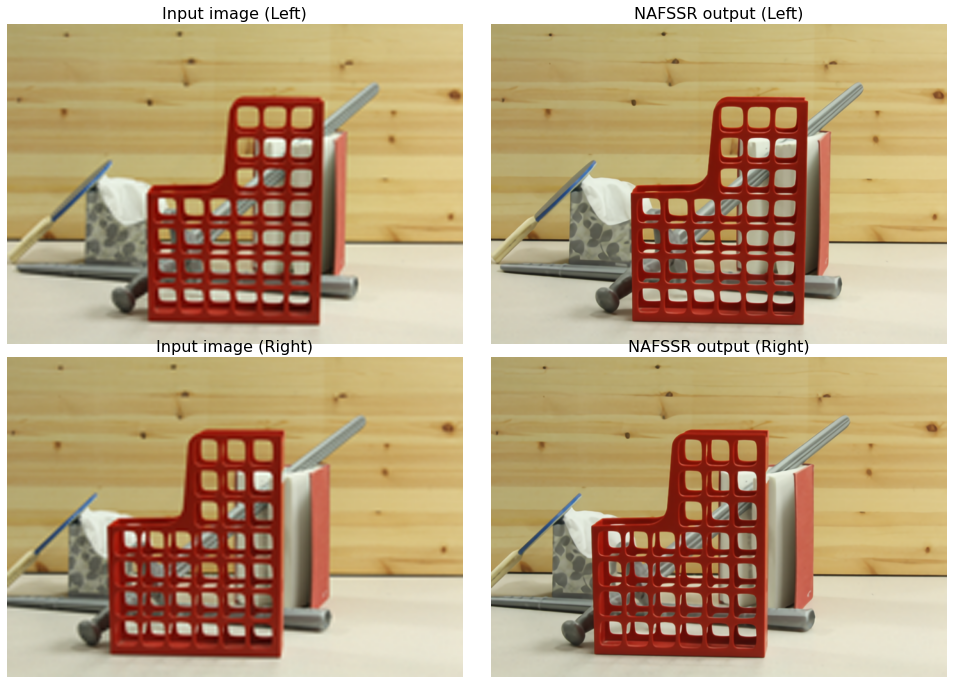

In [ ]:
input_path_l = 'demo_imgs/Middlebury_lr_x4_sword2_l.png'
input_path_r = 'demo_imgs/Middlebury_lr_x4_sword2_r.png'
output_path = 'demo_output/Middlebury_sr_x4_sword2_{}.png'

img_l = imread(input_path_l)
inp_l = img2tensor(img_l)
img_r = imread(input_path_r)
inp_r = img2tensor(img_r)
stereo_image_inference(NAFSSR, inp_l, inp_r, output_path)
SR_l = imread(output_path.format('L'))
SR_r = imread(output_path.format('R'))
display(img_l, img_r, SR_l, SR_r)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


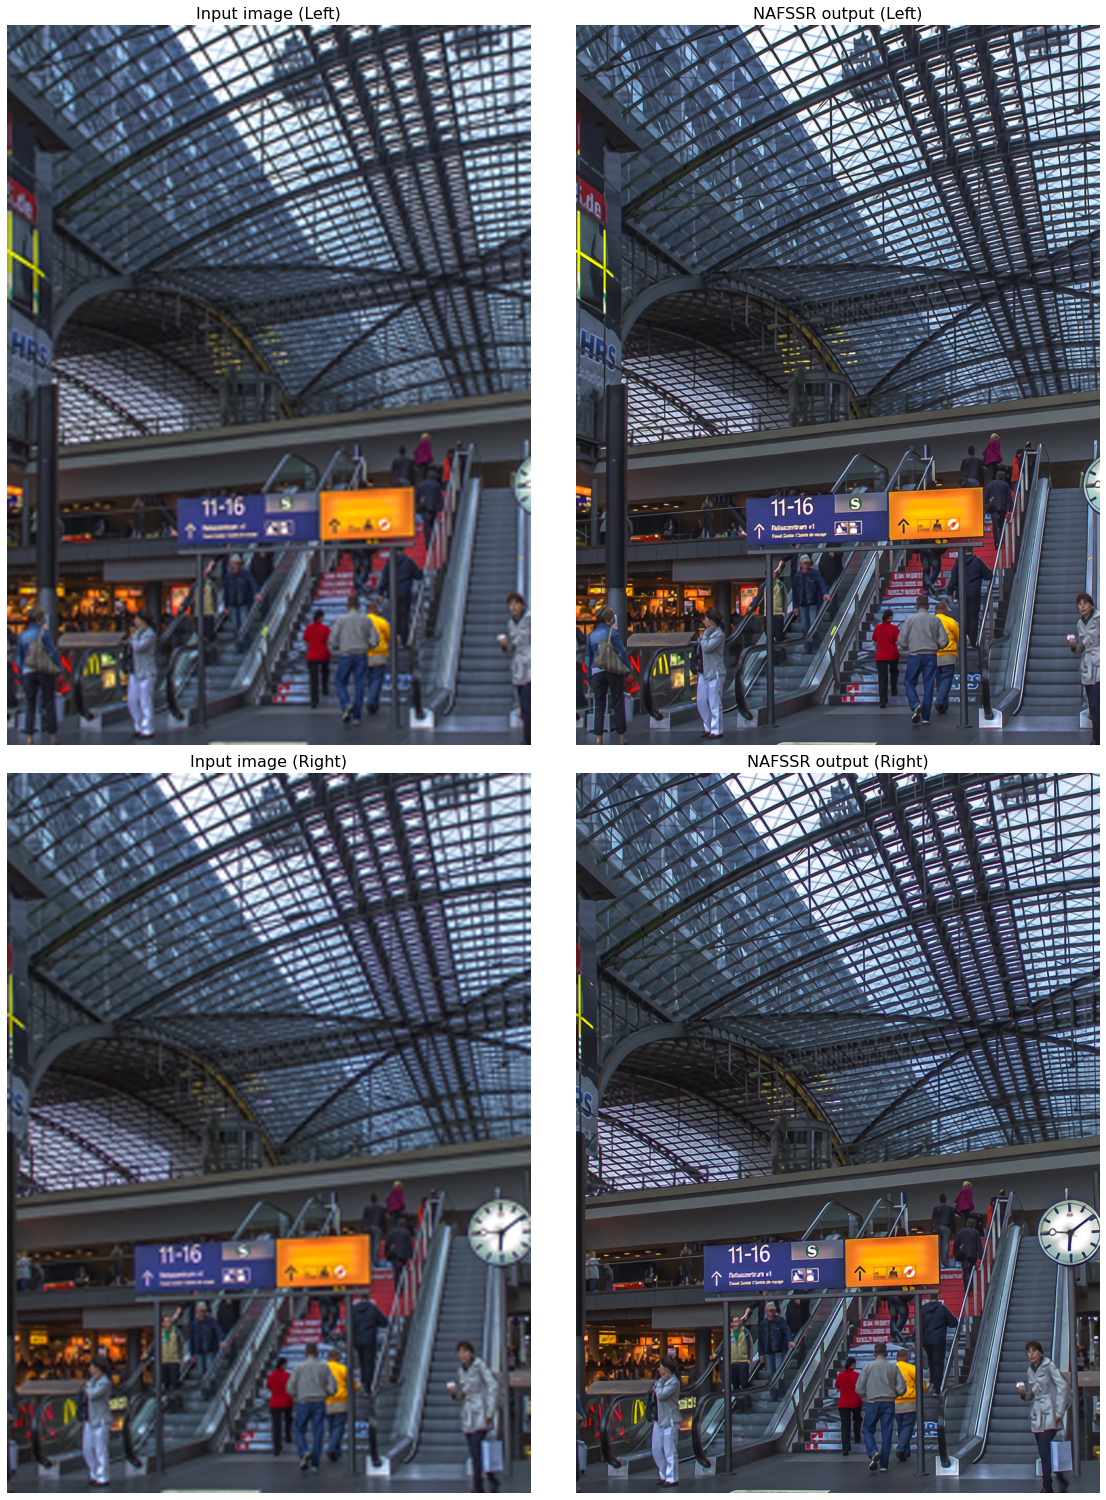

In [ ]:
input_path_l = 'demo_imgs/Flickr1024_lr_x4_0035_l.png'
input_path_r = 'demo_imgs/Flickr1024_lr_x4_0035_r.png'
output_path = 'demo_output/Flickr1024_sr_x4_0035_{}.png'

img_l = imread(input_path_l)
inp_l = img2tensor(img_l)
img_r = imread(input_path_r)
inp_r = img2tensor(img_r)
stereo_image_inference(NAFSSR, inp_l, inp_r, output_path)
SR_l = imread(output_path.format('L'))
SR_r = imread(output_path.format('R'))
display(img_l, img_r, SR_l, SR_r)

## Download results

In [ ]:
import os
from google.colab import files

# download the result
print(f'Download demo_output')
os.system(f'zip -r -j download.zip demo_output/*')
files.download("download.zip")

Download demo_output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>